### **Experiments**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

In [2]:
from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### **Load Data for TIS**

In [3]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

### **Testing Time-Invariant Performance**

In [4]:
%%time
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0
Epoch 50: Training Loss: 0.0109694, Val Loss: 0.0045751
Epoch 100: Training Loss: 0.0036508, Val Loss: 0.0028090
Epoch 150: Training Loss: 0.0065063, Val Loss: 0.0037643
Epoch 200: Training Loss: 0.0044071, Val Loss: 0.0017904
Epoch 250: Training Loss: 0.0039867, Val Loss: 0.0005561
Epoch 300: Training Loss: -0.0005083, Val Loss: 0.0022442
Epoch 350: Training Loss: -0.0078851, Val Loss: -0.0009117
Epoch 400: Training Loss: 0.0027780, Val Loss: -0.0017268
shapes : (1325, 1325, 1325, 1325)
CPU times: total: 5min 13s
Wall time: 57.2 s


In [5]:
tis_cindex , tis_ibs
# (0.6983104083179899, 0.4106011117042349)
# (0.7002156297076692, 0.40314187686834535)
# (0.6926242824650709, 0.40230030777823067)
# (0.6923436684619398, 0.4076280073466049)
# (0.6982267164223191, 0.40493715743536574)

(0.6886218406309385, 0.4045050474527682)

In [6]:
tis.explain_with_shap(background_size = 500 , explained_size = 100)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Expected value -2.178489923477173
Subject value -3.228626012802124


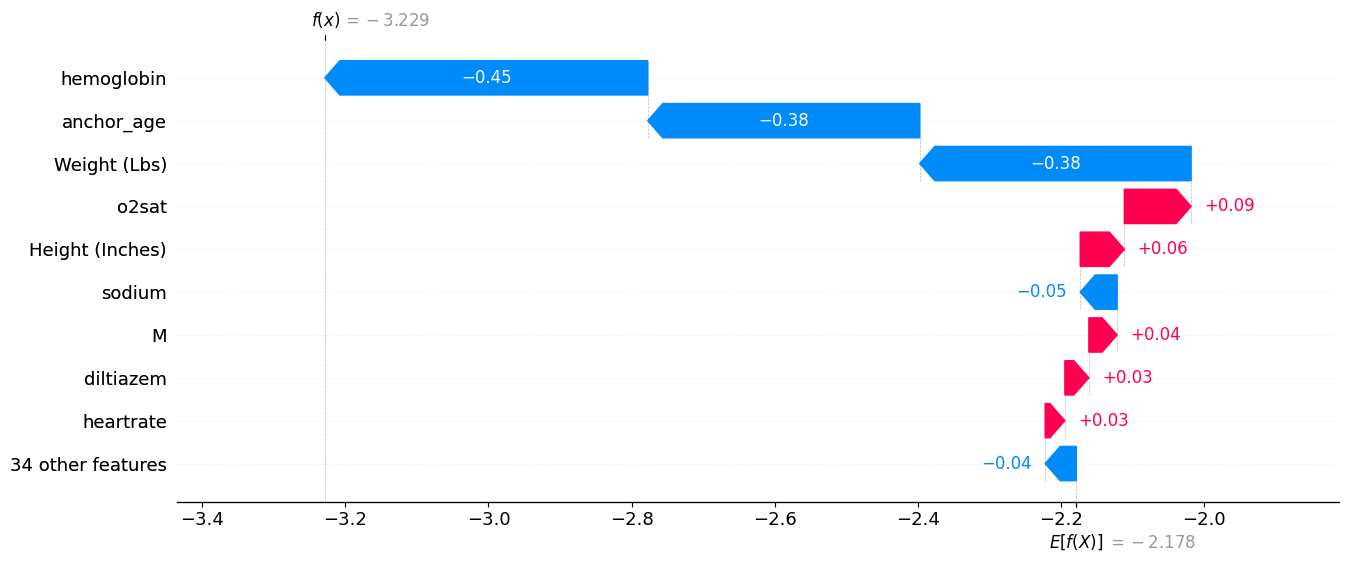

In [7]:
t_s , pat_num = 5 , 50
tis.plot_explain(plot_type = 'waterfall' , t_s = t_s , pat_num = pat_num)

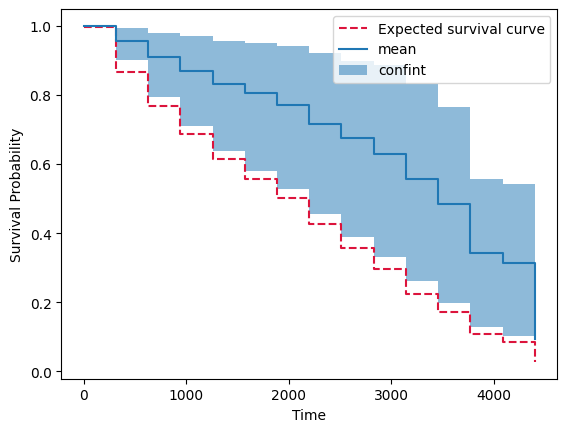

In [13]:
# get death time and event indicator
y_test_dur_ , y_test_event_ = get_target(x_test)

t_test = Transforms(durations = y_test_dur_)
dur_idx_test = t_test.discrete_transform(_cuts = configs['time_invariant']['training']['q_cuts'])

model = tis.nets[0][0]
surv_pat_k = torch.cumprod(1 - torch.sigmoid(model(x_test.iloc[: , :-2].to_numpy())[50 , :]) , dim = 0).detach().numpy()

# Expected survival curve
plt.step(
    t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , 
    where = 'post' , color = 'crimson' , ls = '--' ,
    label = 'Expected survival curve'
    )

mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict()

# Visualize
tis.visualize(mean_ , up_ , low_ , _from = 50 , _to = 51)
plt.legend()
plt.savefig('diff_exp_curve.pdf' , format = 'pdf')
plt.show()

### **Trying to compare survival curves**

In [26]:
# instantiate - CPH
cph = CPH(configs = configs, train_data = x_train, test_data = x_test, val_data = x_val)

# fit
cph.fit()

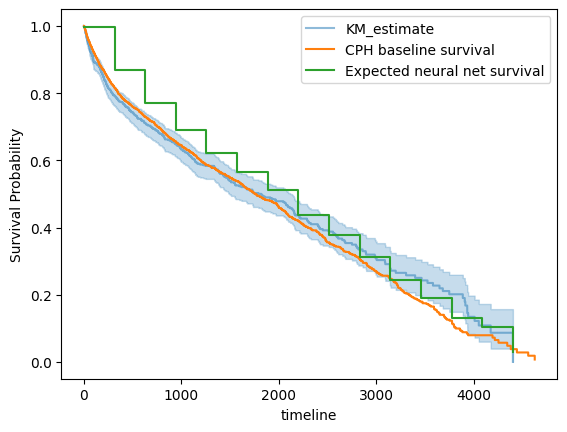

In [39]:
fig , ax = plt.subplots()

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = x_test["time_to_event"]
E = x_test["death"]

kmf.fit(T, event_observed=E)
kmf.plot_survival_function(alpha = 0.5);

# CPH
ax.step((cph.fitter.baseline_survival_).index , (cph.fitter.baseline_survival_)['baseline survival'] , where = 'post' , label = 'CPH baseline survival')

# Expected survival curve
ax.step(t_test.bin_edges , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) , where = 'post' , label = 'Expected neural net survival')
ax.legend()
ax.set_ylabel('Survival Probability');

plt.savefig('comparing_surv_curve.pdf' , format = 'pdf')
plt.show()

#### **Testing Statistical similarity**

In [48]:
import scipy

print(f"KM-NN {scipy.stats.kstest((kmf.survival_function_)['KM_estimate'] , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"CPH-NN {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , np.cumprod(1 - sigmoid(tis.shap_utils[0].expected_value)) )}")
print(f"KM-CPH {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , (kmf.survival_function_)['KM_estimate'] )}")
print(f"KM-CPH {scipy.stats.kstest((cph.fitter.baseline_survival_)['baseline survival']  , (cph.fitter.baseline_survival_)['baseline survival'])}")

KM-NN KstestResult(statistic=0.3442744552619379, pvalue=0.04615058021585876, statistic_location=0.3763355314731598, statistic_sign=-1)
CPH-NN KstestResult(statistic=0.2707332101047443, pvalue=0.18778172592087836, statistic_location=0.3763355314731598, statistic_sign=-1)
KM-CPH KstestResult(statistic=0.08291707264402448, pvalue=0.0019652823109221652, statistic_location=0.48221327789426877, statistic_sign=1)
KM-CPH KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0071306237832859725, statistic_sign=1)


### **Load Data for TVS**

In [9]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('../05_preprocessing_emr_data/data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

### **Testing Time-Variant Performance**

In [12]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Variant Survival
tvs = Time_Variant_Survival(
            configs = configs, 
            x_train_reshape_tv = x_train_reshape_tv,
            x_test_reshape_tv = x_test_reshape_tv, 
            x_val_reshape_tv = x_val_reshape_tv,
            y_train = y_train,
            y_test = y_test,
            y_val = y_val
)

# fit
tvs.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tvs.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tvs_cindex , tvs_ibs = tvs.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

Epoch 50: Training Loss: -0.0020784, Val Loss: 0.0040090
Epoch 100: Training Loss: 0.0012838, Val Loss: 0.0030323
shapes : (1180, 1180, 1180, 1180)


In [20]:
tvs_cindex , tvs_ibs

# (0.7335313759085885, 0.40075786613809444)
# (0.7233037244089423, 0.402674604320726)
# (0.7353032332009801, 0.408018269709824)

(0.7353032332009801, 0.408018269709824)

### **Trying with different cluster size**

In [28]:
# configs['time_invariant']['training']['clusters'] = 1

In [29]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [30]:
tis_cindex , tis_ibs

(0.6887229966307723, 0.4019491137098817)

### **Adding PCA to reduce number of components**

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [70]:
# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

In [71]:
x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

In [72]:
# Check variance captured
np.sum(pca.explained_variance_ratio_)

0.31334215

In [73]:
x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

In [74]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [75]:
tis_cindex , tis_ibs

(0.4891259826914184, 0.4147688930722147)

### **PCA & Clustering**

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

# Check variance captured
print(np.sum(pca.explained_variance_ratio_))

x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

# Increase cluster size
configs['time_invariant']['training']['clusters'] = 2

#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

print(tis_cindex , tis_ibs)

0.6008797
shapes : (1060, 1060, 1060, 1060)
0.4986919468851159 0.4150643009153472


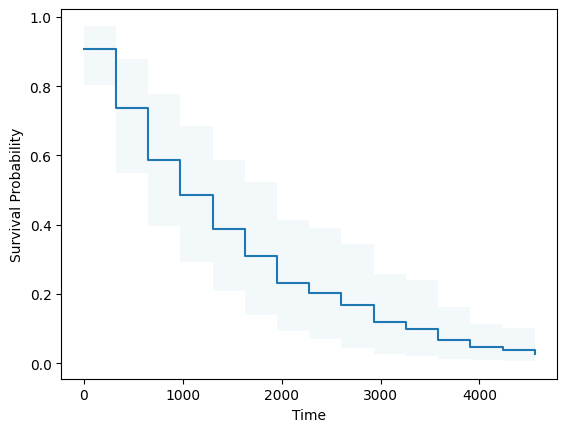

In [5]:
tis.visualize(mean_ , up_ , low_ , _from = 4 , _to = 5 )